In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta

# ВОПРОСЫ
1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)
https://vc.ru/s/productstar/134090-chto-takoe-kogortnyy-analiz


Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.



— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

# Считываю данные c яндекс диска

In [2]:
# для скачивания файлов с URL
import requests 
from urllib.parse import urlencode

# функция для скачивания файлов с Яндекс Диска
def get_download_url_yandexdisc(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return download_url

In [3]:
customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [4]:
customers = pd.read_csv(get_download_url_yandexdisc(customers))
orders = pd.read_csv(get_download_url_yandexdisc(orders), 
                                   parse_dates = [
                                       'order_purchase_timestamp', 
                                       'order_approved_at',
                                       'order_delivered_carrier_date',
                                       'order_delivered_customer_date',
                                       'order_estimated_delivery_date'
                                   ])
items = pd.read_csv(get_download_url_yandexdisc(items), 
                                        parse_dates = ['shipping_limit_date'])

# Считываю данные по локальной сети (альтернативный вариант)

In [2]:
customers = pd.read_csv ('olist_customers_dataset.csv')

orders = pd.read_csv ('olist_orders_dataset.csv', 
                      parse_dates=['order_purchase_timestamp', 'order_approved_at', 
                                   'order_delivered_carrier_date', 'order_delivered_customer_date',
                                  'order_estimated_delivery_date'])

items = pd.read_csv ('olist_order_items_dataset.csv',parse_dates=['shipping_limit_date'])

* Ретроспективно я уже знаю, какие колонки содержат даты (: Поэтому сразу во время считывания корректирую их тип

# Customers. Exploratory Data Analysis 

In [5]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


**customers** — таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя
- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя

In [97]:
# Проверяю тип данных по пользователям
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

* типы данных не требуют корректировки

In [99]:
# Проверяю количество пропущенных значений в таблице
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

* пропущенных значений нет

In [111]:
# Проверяю количество уникальных значений
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

* Количество уникальных идентификаторов customer_id и customer_unique_id различно. Т.е на одного пользователя (customer_unique_id) может быть зарегистрировано несколько customer_id
---
* ниже сгруппирую данные по уникальным пользователям (customer_unique_id), чтобы посмотреть, сколько на 1 пользователя приходится зарегистрированных customer_id:

In [112]:
customers \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .sort_values('customer_id', ascending=False)

,customer_unique_id,customer_id
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...,...
32508,5657dfebff5868c4dc7e8355fea865c4,1
32507,5657596addb4d7b07b32cd330614bdf8,1
32506,5656eb169546146caeab56c3ffc3d268,1
32505,5656a8fabc8629ff96b2bc14f8c09a27,1


# Orders. Exploratory Data Analysis

In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


**orders** —  таблица заказов

- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя
- order_status —  статус заказа
        * created —  создан
        * approved —  подтверждён
        * invoiced —  выставлен счёт
        * processing —  в процессе сборки заказа
        * shipped —  отгружен со склада
        * delivered —  доставлен пользователю
        * unavailable —  недоступен
        * canceled —  отменён
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

In [113]:
# Проверяю тип данных по заказам
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

* колонки с датами в нужном формате datetime64

In [114]:
# Проверяю количество пропущенных значений в таблице
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

* пропущены значения есть в колонках order_approved_at (время подтверждения оплаты заказа), order_delivered_carrier_date (время передачи заказа в логистическую службу), order_delivered_customer_date (время доставки заказа). Это нормально, т.к заказ находится на разных этапах от создания до доставки, и эти колонки будут заполнены данными по мере доставки товара.

In [116]:
# Проверяю количество уникальных значений
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

* каждому customer_id соответствует всего один заказ, т.к количество заказов совпадает с количеством пользователей

In [128]:
# Сгруппирую заказы по их статусу и оценю основные логистические даты
orders \
    .groupby('order_status', as_index=False) \
    .agg({'order_purchase_timestamp': 'count', 
           'order_approved_at': 'count', 
           'order_delivered_carrier_date': 'count', 
           'order_delivered_customer_date': 'count'}
        )

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,approved,2,2,0,0
1,canceled,625,484,75,6
2,created,5,0,0,0
3,delivered,96478,96464,96476,96470
4,invoiced,314,314,0,0
5,processing,301,301,0,0
6,shipped,1107,1107,1107,0
7,unavailable,609,609,0,0


**каждый товар заказа проходит следующие последовательные стадии (order_status):**

* created (создан) - approved (подтверждён) - invoiced (выставлен счёт) - processing (в процессе сборки заказа) - shipped (отгружен со склада) - delivered (доставлен пользователю)
* опционально товар может так же быть unavailable (недоступен) и canceled (отменён)

**Обращает на себя внимание:**


* Всего 625 заказов отменено. Часть из них оплачена (484), часть передана в логистическую службу (75), что нормально, ведь отмена заказа может произойти на различных этапах транспортировки товара. Однако часть отменена уже после доставки (6)
(?) логичнее было бы иметь отдельную колонку 'возвраты', чтобы не возникала путанница

* Всего доставлено 96478 заказа, однако подтверждение оплаты есть только у 96464 пользователей, время передачи заказа в логистическую службу - у 96476, время доставки - у 96470. Т.е на каждом этапе нарушена корректная запись данных

# Items. Exploratory Data Analysis 

In [59]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


**items**  —  товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

In [118]:
# Проверяю тип данных по заказам
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

* колонки с датами в нужном формате datetime64

In [119]:
# Проверяю количество пропущенных значений в таблице
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

* пропущенных значений нет

In [121]:
# Проверяю количество уникальных значений
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

* order_id в таблице items (98666) и orders (99441) различны. Т.е в таблице items отсутствуют данные о 775 товарах

# Что должно считаться покупкой?

заказ, который был оплачен, вне зависимости от возможного последующего возврата, можем считать покупкой:

In [10]:
#Количество заказов (по времени подтверждения оплаты заказа)
orders.order_approved_at.count()

99281

# Задание 1
## Сколько у нас пользователей, которые совершили покупку только один раз?

In [3]:
# объединяю таблицы с данными о покупателях и заказах 
purchases = customers.merge(orders, on='customer_id', how='inner')
purchases.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [5]:
# Считаю количество уникальных пользователей, совершивших всего одну покупку
the_only_one_purchase = purchases \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_approved_at':'count'}) \
    .query('order_approved_at == 1') \
    .customer_unique_id.nunique()
the_only_one_purchase

93049

* Всего 93049 пользователя совершили лишь одну покупку. Но что это значит относительно всех пользователей ?

In [6]:
# Считаю в процентном соотношении:
round((the_only_one_purchase / purchases.customer_unique_id.count()) * 100)

94

* 94% всех пользователей совершили лишь одну покупку

In [7]:
# Пользователь, совершивший наибольшее количество покупок 
purchases \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_approved_at': 'count'}) \
    .max()

customer_unique_id    ffffd2657e2aad2907e67c3e9daecbeb
order_approved_at                                   17
dtype: object

* Наиболее лояльный пользователь (17 покупок) - ffffd2657e2aad2907e67c3e9daecbeb

# Задание 2
## Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

#### заказы, которые не доставляются..
            = заказы, которые не доставляются вовремя (order_delivered_customer_date > order_estimated_delivery_date)
#### или
            = заказы, у которых нет данных о дате доставки (поиск логических ошибок в данных)
#### или
            = заказы, которые отменены (canceled) или не доступны (unavailable)

#### (?)


#### будем считать, что речь о canceled и unavailable

In [8]:
# Создаю колонку с ожидаемым временем доставки в виде 'год/месяц'
orders['estimated_delivery_month'] = orders.order_estimated_delivery_date.dt.strftime('%Y/%m')

In [9]:
# Создаю таблицу с заказами, которые были отменены или не доступны
non_delivered_orders = orders \
    .query('order_status == "unavailable" or order_status == "canceled"')
non_delivered_orders.shape

(1234, 9)

In [10]:
# Считаю количество canceled и unavailable за все время
non_delivered_orders \
    .groupby('order_status', as_index=False) \
    .agg({'order_id' : 'count'}) 

,order_status,order_id
0,canceled,625
1,unavailable,609


* всего за весь период не доставлено 1234 заказа, из них 625 отменено, 609 - не доступно

In [11]:
# Считаю, сколько заказов не доставляется за каждый период (месяц)
non_delivered_orders.groupby('estimated_delivery_month', as_index = False) \
    .agg({'order_id':'count'}) \
    .sort_values('estimated_delivery_month')

,estimated_delivery_month,order_id
0,2016/09,1
1,2016/10,3
2,2016/11,19
3,2016/12,10
4,2017/02,4
5,2017/03,92
6,2017/04,41
7,2017/05,39
8,2017/06,58
9,2017/07,55


In [12]:
# Считаю, сколько заказов не доставляется за каждый месяц В СРЕДНЕМ
non_delivered_orders.groupby('estimated_delivery_month', as_index = False) \
    .agg({'order_id':'count'}) \
    .sort_values('estimated_delivery_month') \
    .mean()

order_id    47.461538
dtype: float64

* среднее количество не доставленных заказов в месяц - 47

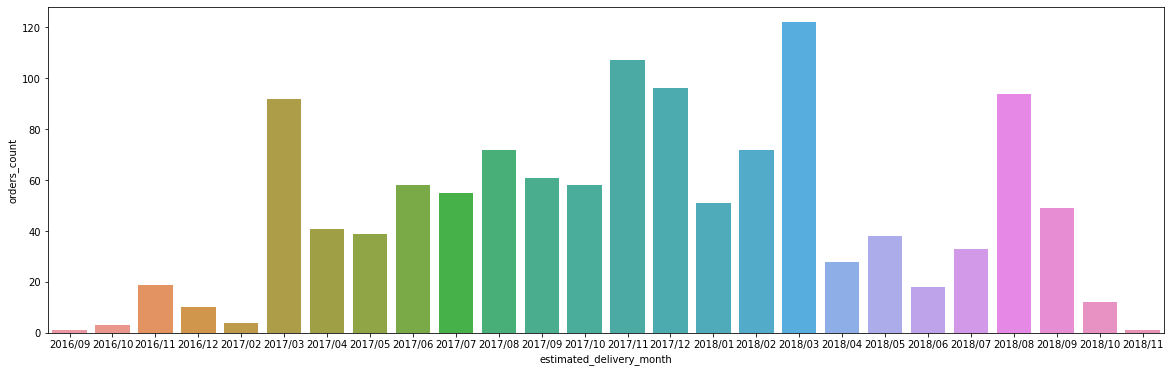

In [117]:
# Строю график по данным из таблицы не доставленных зказов (количество) с разбивкой по месяцам за весь период
fig, ax = plt.subplots(figsize=(20, 6))

sns.barplot(data = non_delivered_orders.groupby('estimated_delivery_month', as_index = False) \
    .agg({'order_id':'count'}) \
    .sort_values('estimated_delivery_month') \
    .rename(columns={'order_id':'orders_count'}), x = 'estimated_delivery_month', y = 'orders_count')

# Задание 3
## По каждому товару определить, в какой день недели товар чаще всего покупается

In [119]:
# объединяю таблицы с данными о заказах и товарах
purchases_items = orders.merge(items, on='order_id', how='inner')

* поскольку в качестве покупки рассматриваю **оплаченный** заказ, который **не был отменен**, отберу лишь необходимые значения:

In [120]:
purchases_items = purchases_items \
    .query('order_status != "canceled"')

In [121]:
# создаю столбец с днями недели покупок
purchases_items['purchase_weekday'] = purchases_items.order_purchase_timestamp.dt.day_name()

In [142]:
purchases_items.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_delivery_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,purchase_weekday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017/10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018/08,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018/09,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday


### Cчитаю количество покупок каждого товара (product_id) в различные дни недели:

In [156]:
# объединяю таблицы с данными о заказах и товарах
purchases_items = orders.merge(items, on='order_id', how='inner')

In [157]:
purchases_items = purchases_items \
    .query('order_status != "canceled"')

In [158]:
# создаю столбец с днями недели покупок
purchases_items['purchase_weekday'] = purchases_items.order_purchase_timestamp.dt.day_name()

In [159]:
purchases_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_delivery_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,purchase_weekday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017/10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018/08,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018/09,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017/12,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018/02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [160]:
# Считаю количество покупок каждого товара по дням
purchases_items_weekday = purchases_items \
    .groupby(['product_id', 'purchase_weekday'], as_index = False) \
    .agg({'order_id' : 'count'})

In [161]:
# Для дальнейшего применения idxmax() 'разворачиваю' таблицу
purchases_items_weekday = pd.pivot_table(purchases_items_weekday, values='order_id', columns='product_id', index='purchase_weekday')

#### Считаю, в какой день недели для каждого product_id было наибольшее количество покупок:



In [165]:
purchases_items_weekday \
    .idxmax() \
    .to_frame() \
    .reset_index() \
    .rename(columns={0: 'day_name'})

,product_id,day_name
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32730,fff6177642830a9a94a0f2cba5e476d1,Saturday
32731,fff81cc3158d2725c0655ab9ba0f712c,Monday
32732,fff9553ac224cec9d15d49f5a263411f,Friday
32733,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


# Задание 4
## Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [4]:
# данные о покупателях и заказах 
purchases.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


**Создаю таблицу purchases_unique, в которой считаю количество заказов (order_id) с группировкой по уникальному id пользователя (customer_unique_id) и времени подтверждения оплаты заказа (order_approved_at):**

In [5]:
purchases_unique = purchases \
    .groupby(['customer_unique_id', 'order_approved_at'], as_index = False) \
    .agg({'order_id' : 'count'})

In [6]:
# Извлекаю из столбца order_approved_at
#    -количество дней в текущем месяце
#    -название месяца
#    -год

purchases_unique['daysinmonth'] = purchases_unique.order_approved_at.dt.daysinmonth
purchases_unique['year'] = purchases_unique.order_approved_at.dt.year
purchases_unique['order_approved_at'] = purchases_unique.order_approved_at.dt.month_name()

In [7]:
# Считаю количество недель (количество дней в месяц делю на 7)
purchases_unique['week'] = purchases_unique.daysinmonth / 7

In [8]:
purchases_unique.head()

,customer_unique_id,order_approved_at,order_id,daysinmonth,year,week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,1,31,2018,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,1,31,2018,4.428571
2,0000f46a3911fa3c0805444483337064,March,1,31,2017,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,October,1,31,2017,4.428571
4,0004aac84e0df4da2b147fca70cf8255,November,1,30,2017,4.285714


**Отбираю значения за 2017 год (т.к имеются собранные даныные за весь год только в 2017)
Группирую по customer_unique_id, месяцу, неделе, и вычисляю среднее число заказов:**

In [10]:
purchases_unique_2017 = purchases_unique.query("year == 2017") \
    .groupby(['customer_unique_id', 'order_approved_at', 'week'],  as_index = False) \
    .agg({'order_id' : 'mean'}) \
    .sort_values('order_id', ascending = False)
purchases_unique_2017

,customer_unique_id,order_approved_at,week,order_id
18414,6a80a86f478a93a5f4c7ba8db6441a6b,July,4.428571,3.0
15217,57a00f215e83a19190f6a5dded389806,February,4.000000,2.0
16144,5cfc9643603c095fd7ed86a50fa17887,November,4.285714,2.0
20301,754f0aa37a9a58685e42e70973bc511c,August,4.428571,2.0
10282,3b6f5d22fb32e6ac2fbbb944b18cf1bb,July,4.428571,2.0
...,...,...,...,...
14746,54de682f0fdd9e588983277f98bdd15d,June,4.285714,1.0
14747,54df929c8defcf5055528c4fc49cba1c,November,4.285714,1.0
14748,54e0a7cc9c09c591bd186e4569c7bf30,March,4.428571,1.0
14749,54e2366c118c48a816218411feb62215,July,4.428571,1.0


In [11]:
# Cоздаю столбец avg_orders_per_week, в котором считаю среднее число заказов в неделю для каждого месяца
purchases_unique_2017['avg_orders_per_week'] = purchases_unique_2017.order_id / purchases_unique_2017.week

In [12]:
purchases_unique_2017.head()

,customer_unique_id,order_approved_at,week,order_id,avg_orders_per_week
18414,6a80a86f478a93a5f4c7ba8db6441a6b,July,4.428571,3.0,0.677419
15217,57a00f215e83a19190f6a5dded389806,February,4.000000,2.0,0.500000
16144,5cfc9643603c095fd7ed86a50fa17887,November,4.285714,2.0,0.466667
20301,754f0aa37a9a58685e42e70973bc511c,August,4.428571,2.0,0.451613
10282,3b6f5d22fb32e6ac2fbbb944b18cf1bb,July,4.428571,2.0,0.451613


In [13]:
# Cоздаю таблицу avg_orders (среднее количество покупок каждого уникального пользователя в неделю для каждого месяца)
avg_orders = pd.pivot_table(purchases_unique_2017, values='avg_orders_per_week', columns='order_approved_at', index='customer_unique_id', fill_value=0)

In [14]:
# Привожу к привычной последовательности месяцы в году
avg_orders = avg_orders[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

In [15]:
avg_orders

order_approved_at,January,February,March,April,May,June,July,August,September,October,November,December
customer_unique_id,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,0.0,0.00,0.225806,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.225806,0.000000,0.000000
0004aac84e0df4da2b147fca70cf8255,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.233333,0.000000
0005e1862207bf6ccc02e4228effd9a0,0.0,0.00,0.225806,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.225806,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.225806
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.00,0.000000,0.0,0.000000,0.233333,0.000000,0.0,0.0,0.000000,0.000000,0.000000
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.225806


In [27]:
avg_orders.max()

order_approved_at
January      0.451613
February     0.500000
March        0.451613
April        0.466667
May          0.451613
June         0.466667
July         0.677419
August       0.451613
September    0.466667
October      0.451613
November     0.466667
December     0.451613
dtype: float64

# Задание 5
## Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

1. Retention – показатель, который показывает, сколько пользователей возвращается в продукт через определенное количество времени;
2. Т.е первичное действие -  дата создания первого заказа, а retention - даты создания повторных заказов (вне зависимости от факта оплаты, доставки и т.д, потому что сам факт создания заказа пользователем уже является отражением его активности по отношению к нашему онлайн магазину);
3. Для исследования retention необходимо разбить пользователей на когорты по месяцу создания их первого заказа и посчитать количество пользователей в каждой когорте для определения ее размера;
4. Далее для каждой когорты посчитать количество повторных заказов за каждый месяц искомого периода (с января по декабрь);
5. Выявить когорту с самым выскоим retention на третий месяц.

In [3]:
# Объединяю таблицы заказов и покупателей
customers_orders = orders.merge(customers[['customer_id', 'customer_unique_id']], on = 'customer_id', how = 'inner')

In [4]:
# Создаю колонку месяца покупки товара
customers_orders['order_approved_at_month'] = customers_orders['order_approved_at'].dt.strftime('%Y-%m')

In [5]:
# Отбираю нужный временной интервал (с января по декабрь 2017 года)
cohort_2017 = customers_orders \
        .query("(order_approved_at >= datetime.strptime('2017-01', '%Y-%m')) \
               & (order_approved_at < datetime.strptime('2018-01', '%Y-%m'))")
cohort_2017

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,order_approved_at_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,2017-10
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,2017-11
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,2017-07
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,2017-04
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,2017-05
...,...,...,...,...,...,...,...,...,...,...
99433,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,2017-10
99434,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,2017-01
99435,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,2017-02
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,2017-03


In [6]:
# Cоздаю колонку с месяцем первой покупки для каждого пользователя (выделение когорт)
cohort_2017.set_index('customer_unique_id', inplace=True)
cohort_2017 = cohort_2017 \
                .assign(cohort_month = cohort_2017 \
                                .groupby(level=0)['order_approved_at'] \
                                .min() \
                                .apply(lambda x: x.strftime('%Y-%m'))) #добавит cohort_month
cohort_2017.reset_index(inplace=True)
cohort_2017.insert(len(cohort_2017.columns), 'orders_total', 0, allow_duplicates=False) 
cohort_2017

,customer_unique_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at_month,cohort_month,orders_total
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,2017-09,0
1,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,2017-11,0
2,80bb27c7c16e8f973207a5086ab329e2,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,2017-07,2017-07,0
3,36edbb3fb164b1f16485364b6fb04c73,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-04,2017-04,0
4,932afa1e708222e5821dac9cd5db4cae,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,2017-05,2017-05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44968,c716cf2b5b86fb24257cffe9e7969df8,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,2017-10,2017-10,0
44969,e03dbdf5e56c96b106d8115ac336f47f,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,2017-01,2017-01,0
44970,831ce3f1bacbd424fc4e38fbd4d66d29,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,2017-02,2017-02,0
44971,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017-03,2017-03,0


In [7]:
# Группирую по месяцу когорты и месяцу покупки товара
# Считаю количество customer_unique_id и общее количество оплаченных заказов

cohort_2017_var = cohort_2017.groupby(['cohort_month', 'order_approved_at_month'])
# 
cohort_2017_var = cohort_2017 \
                    .groupby(['cohort_month', 'order_approved_at_month']) \
                    .agg({'customer_unique_id': pd.Series.nunique, 'orders_total': pd.Series.count})

cohort_2017_var.head()

customer_unique_id  orders_total
cohort_month order_approved_at_month                                  
2017-01      2017-01                                 727           760
             2017-02                                   4             4
             2017-03                                   2             2
             2017-04                                   1             1
             2017-05                                   3             3

In [8]:
# Создаю колонку с порядковым номером определенного периода когорты для каждого месяца
cohort_2017_var.reset_index(inplace = True)
cohort_2017_var['cohort_rank'] = cohort_2017_var \
                                .reset_index(inplace = False) \
                                .order_approved_at_month \
                                .apply(lambda x: int(x.split('-')[1])) - cohort_2017_var.cohort_month \
                                .apply(lambda x: int(x.split('-')[1]))
cohort_2017_var.set_index(['cohort_month', 'order_approved_at_month'], inplace=True)
cohort_2017_var

customer_unique_id  orders_total  \
cohort_month order_approved_at_month                                     
2017-01      2017-01                                 727           760   
             2017-02                                   4             4   
             2017-03                                   2             2   
             2017-04                                   1             1   
             2017-05                                   3             3   
...                                                  ...           ...   
2017-10      2017-11                                  30            32   
             2017-12                                  13            13   
2017-11      2017-11                                7164          7269   
             2017-12                                  39            41   
2017-12      2017-12                                5638          5704   

                                      cohort_rank  
cohort_month order_approved_at_month               
2017-01      2017-01                            0  
             2017-02                            1  
             2017-03                            2  
             2017-04                            3  
             2017-05                            4  
...                                           ...  
2017-10      2017-11                            1  
             2017-12                            2  
2017-11      2017-11                            0  
             2017-12                            1  
2017-12      2017-12                            0  

[77 rows x 3 columns]

In [9]:
# Проверка пропусков значений в месяцах
cohort_2017_var \
    .reset_index(inplace = False) \
    .query("cohort_month == '2017-01'") 

,cohort_month,order_approved_at_month,customer_unique_id,orders_total,cohort_rank
0,2017-01,2017-01,727,760,0
1,2017-01,2017-02,4,4,1
2,2017-01,2017-03,2,2,2
3,2017-01,2017-04,1,1,3
4,2017-01,2017-05,3,3,4
5,2017-01,2017-06,1,1,5
6,2017-01,2017-07,4,4,6
7,2017-01,2017-08,1,1,7
8,2017-01,2017-09,1,1,8
9,2017-01,2017-11,2,2,10


* после месяца order_approved_at_month '2017-09' следует '2017-11'; также пропускается cohort_rank 9

In [10]:
# Переиндексирую df
cohort_2017_var.reset_index(inplace=True)
cohort_2017_var.set_index(['cohort_rank','cohort_month'], inplace=True)

# Создаю ряд, содержаший размер каждой когорты cohort_month
cohort_size = cohort_2017_var['customer_unique_id'] \
                                .groupby(level=1).first()
cohort_size.head()

cohort_month
2017-01     727
2017-02    1736
2017-03    2643
2017-04    2324
2017-05    3592
Name: customer_unique_id, dtype: int64

In [11]:
# Изменяет конфигурацию cohort_2017_var
cohort_2017_var['customer_unique_id'].unstack(1)

cohort_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_rank,,,,,,,,,,,,
0,727.0,1736.0,2643.0,2324.0,3592.0,3148.0,3844.0,4204.0,4149.0,4433.0,7164.0,5638.0
1,4.0,4.0,13.0,14.0,19.0,15.0,20.0,28.0,27.0,30.0,39.0,NaN
2,2.0,4.0,9.0,5.0,18.0,11.0,13.0,15.0,20.0,13.0,NaN,NaN
3,1.0,3.0,9.0,4.0,14.0,13.0,8.0,11.0,14.0,NaN,NaN,NaN
4,3.0,7.0,9.0,7.0,11.0,8.0,13.0,16.0,NaN,NaN,NaN,NaN
5,1.0,2.0,4.0,6.0,12.0,11.0,7.0,NaN,NaN,NaN,NaN,NaN
6,4.0,4.0,4.0,8.0,15.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,3.0,8.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,2.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# В полях проставлены значения retention
retention = cohort_2017_var['customer_unique_id'].unstack(0).divide(cohort_size, axis=0)
retention

cohort_rank,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-01,1.0,0.005502,0.002751,0.001376,0.004127,0.001376,0.005502,0.001376,0.001376,NaN,0.002751,0.002751
2017-02,1.0,0.002304,0.002304,0.001728,0.004032,0.001152,0.002304,0.001728,0.001152,0.002304,0.001152,NaN
2017-03,1.0,0.004919,0.003405,0.003405,0.003405,0.001513,0.001513,0.003027,0.003027,0.001135,NaN,NaN
2017-04,1.0,0.006024,0.002151,0.001721,0.003012,0.002582,0.003442,0.002582,0.003442,NaN,NaN,NaN
2017-05,1.0,0.005290,0.005011,0.003898,0.003062,0.003341,0.004176,0.001670,NaN,NaN,NaN,NaN
2017-06,1.0,0.004765,0.003494,0.004130,0.002541,0.003494,0.003812,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005203,0.003382,0.002081,0.003382,0.001821,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006660,0.003568,0.002617,0.003806,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006508,0.004820,0.003374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


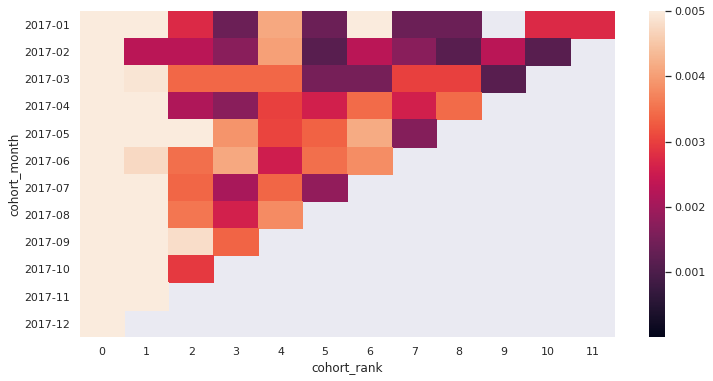

In [20]:
sns.set (rc={"figure.figsize": (12, 6)})
sns.heatmap(retention, vmin=0.0000002, vmax = 0.005)

In [13]:
# Преобразование для визуализации
retention_table = (retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='Purples')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
retention_table

cohort_rank,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-01,100.00%,0.55%,0.28%,0.14%,0.41%,0.14%,0.55%,0.14%,0.14%,,0.28%,0.28%
2017-02,100.00%,0.23%,0.23%,0.17%,0.40%,0.12%,0.23%,0.17%,0.12%,0.23%,0.12%,
2017-03,100.00%,0.49%,0.34%,0.34%,0.34%,0.15%,0.15%,0.30%,0.30%,0.11%,,
2017-04,100.00%,0.60%,0.22%,0.17%,0.30%,0.26%,0.34%,0.26%,0.34%,,,
2017-05,100.00%,0.53%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,,,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.35%,0.38%,,,,,
2017-07,100.00%,0.52%,0.34%,0.21%,0.34%,0.18%,,,,,,
2017-08,100.00%,0.67%,0.36%,0.26%,0.38%,,,,,,,
2017-09,100.00%,0.65%,0.48%,0.34%,,,,,,,,


* **В период с января по декабрь 2017 года самый высокий retention наблюдается в когорте пользователей, совершивших первый заказ в июне 2017**